# **⚛ Analisis NO Supervisado - Calidad del Aire -**

## **📘 Introducción**
La calidad del aire en entornos urbanos es un tema de creciente interés debido a sus implicaciones directas en la salud pública, el cambio climático y la planificación urbana sostenible. En este contexto, la ciudad de Madrid presenta desafíos específicos por su densidad poblacional, su elevada carga vehicular y las condiciones meteorológicas que en ocasiones favorecen la acumulación de contaminantes.

El presente análisis aplica técnicas de aprendizaje no supervisado, específicamente el algoritmo de clustering, con el objetivo de identificar patrones ocultos en los datos ambientales y de tráfico. A diferencia de los enfoques supervisados, este método no requiere etiquetas previas, lo que permite descubrir agrupaciones naturales de días según sus características atmosféricas, niveles de contaminación y actividad urbana.

Mediante esta metodología, se han clasificado los días del periodo analizado en tres grupos (clusters) con perfiles ambientales y de calidad del aire bien diferenciados. El análisis abarca variables como concentraciones de contaminantes (NO₂, SO₂, ozono, PM10, PM2.5), condiciones meteorológicas (temperatura, humedad, presión, viento), intensidad del tráfico y la presencia de eventos especiales.

Este enfoque permite no solo describir los contextos típicos que dan lugar a episodios de alta o baja calidad del aire, sino también informar políticas públicas y estrategias de mitigación. En última instancia, el objetivo es proporcionar una herramienta de diagnóstico útil para anticipar situaciones críticas y diseñar intervenciones más eficaces.

## **🛠️ Instalación de las librerias**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## **📊 Visualización de nuestros datos**

In [ ]:
df = pd.read_csv('Final_data.csv')
print(df.head())
print(df.describe())
print(df.info())

        Fecha  Media_Dioxido_Nitrogeno  Min_Dioxido_Nitrogeno  \
0  2021-01-01                14.875000                      3   
1  2021-01-02                24.541667                      9   
2  2021-01-03                32.583333                     17   
3  2021-01-04                32.083333                     12   
4  2021-01-05                53.708333                     28   

   Max_Dioxido_Nitrogeno  Media_Humedad_Relativa  Min_Humedad_Relativa  \
0                     23               67.826087                    60   
1                     36               55.130435                    47   
2                     42               61.727273                    53   
3                     47               60.772727                    56   
4                     67               66.136364                    52   

   Max_Humedad_Relativa  Media_Dioxido_Azufre  Min_Dioxido_Azufre  \
0                    74                   3.2                   2   
1                    66   

In [ ]:
df1 = pd.read_csv('aqi_personalizado_data_final.csv')
print(df1.head())
print(df1.describe())
print(df1.info())

        Fecha  AQI_O3  AQI_SO2  Media_Temperatura  Media_viento  \
0  2021-01-01      54        5           3.972000          1.67   
1  2021-01-02      44        5           2.224000          1.15   
2  2021-01-03      29        5           2.308333          1.20   
3  2021-01-04      38        5           2.933333          1.23   
4  2021-01-05      17        7           1.212500          0.57   

   diferencia_trafico_en_zbe_centro  AQI_PM10  AQI_PM2.5  \
0                          -26.1060         4         14   
1                          -11.9976         5         14   
2                          -22.4208         8         23   
3                          -29.7894         7         20   
4                          -51.8846        16         47   

   Media_Humedad_Relativa  AQI_NO2  Media_Presion_Barometrica  \
0               67.826087       14                    938.500   
1               55.130435       23                    941.125   
2               61.727273       31       

Añadimos a nuestro conjunto de datos creado el AQI personalizado que hemos conseguido con nuestro Modelo XGBoostRegressor

In [ ]:
df = pd.concat([df, df1[['AQI_personalizado', 'Clasificacion_AQI_Personalizado', 'Color_AQI_Personalizado']]], axis=1)

print(df.head())


        Fecha  Media_Dioxido_Nitrogeno  Min_Dioxido_Nitrogeno  \
0  2021-01-01                14.875000                      3   
1  2021-01-02                24.541667                      9   
2  2021-01-03                32.583333                     17   
3  2021-01-04                32.083333                     12   
4  2021-01-05                53.708333                     28   

   Max_Dioxido_Nitrogeno  Media_Humedad_Relativa  Min_Humedad_Relativa  \
0                     23               67.826087                    60   
1                     36               55.130435                    47   
2                     42               61.727273                    53   
3                     47               60.772727                    56   
4                     67               66.136364                    52   

   Max_Humedad_Relativa  Media_Dioxido_Azufre  Min_Dioxido_Azufre  \
0                    74                   3.2                   2   
1                    66   

In [ ]:
df.to_csv('new_data.csv', index=False)


In [ ]:
# Cargar los datos
df = pd.read_csv('new_data.csv')

## **💻 Análilsis no supervisado K-MEANS**

### **🧹 Preparación de los datos**

In [ ]:
# Eliminar columnas no numéricas o irrelevantes para clustering
df_clustering = df.drop(columns=[
    'Fecha',
    'Clasificacion_AQI_Personalizado',
    'Color_AQI_Personalizado'
])

# Opcional: eliminar la columna del AQI personalizado si no se quiere usar como base del clustering
df_clustering = df_clustering.drop(columns=['AQI_personalizado'])

# Separar la variable binaria antes de escalar
binarias = df_clustering[['evento_especial']]
continuas = df_clustering.drop(columns=['evento_especial'])

# Escalar solo las continuas
scaler = StandardScaler()
X_scaled_continuas = scaler.fit_transform(continuas)

# Concatenar nuevamente
X_scaled = np.concatenate([X_scaled_continuas, binarias.values], axis=1)


# Reducir la dimensionalidad para visualización con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)




### **🚀 Encontrar los Clusters optimos**

**✅ 1. Método del codo**

Mide la "inercia", también conocida como:

Suma de los errores cuadráticos dentro del cluster (WCSS):

Es decir, qué tan lejos están los puntos de datos de su centro de cluster.

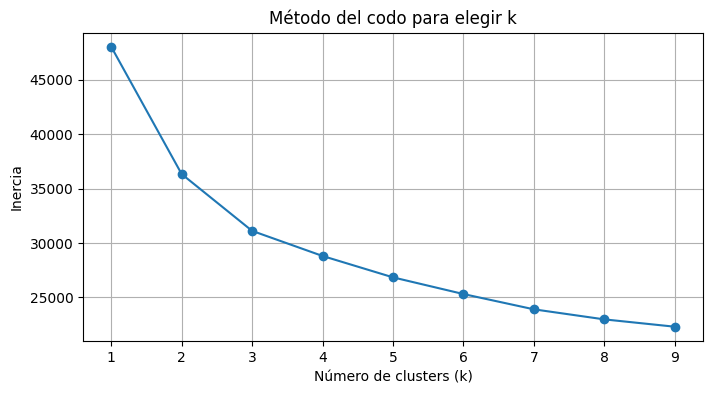

In [ ]:
# Encontrar número óptimo de clusters (opcional)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
#   silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar curva del codo
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Método del codo para elegir k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid()
plt.show()

**✅ 2. Silhouette Score**

Mide qué tan bien cada punto se ajusta a su propio cluster en comparación con otros.

Cuanto más alto (cerca de 1), mejor.

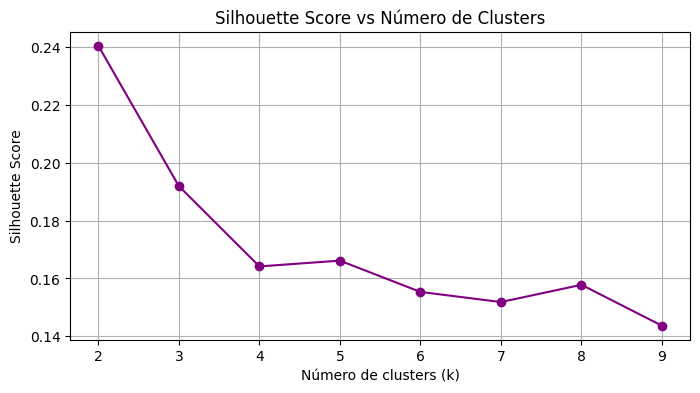

In [ ]:

silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, marker='o', color='purple')
plt.title('Silhouette Score vs Número de Clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


**✅ 3. Davies-Bouldin Index**

Cuanto más bajo es el valor, mejor es la separación entre los clusters.

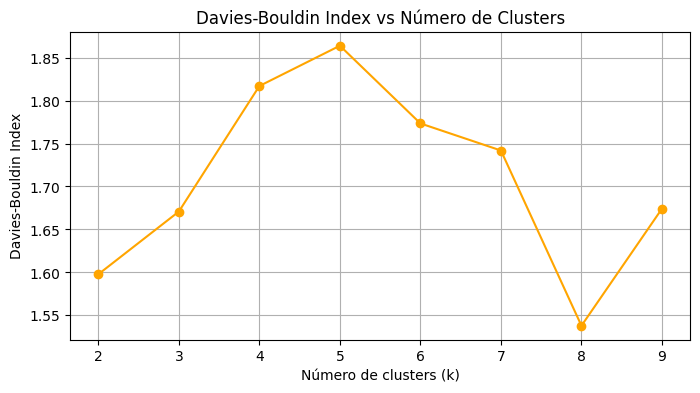

In [ ]:
db_scores = []
for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(K, db_scores, marker='o', color='orange')
plt.title('Davies-Bouldin Index vs Número de Clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.grid()
plt.show()


### 📊 **Visualización y análisis de los Clusters Optimos**

Los dos posibles numeros de clusters ha probar eran el 3 y el 5, pero a la hora de visualizarlos, hemos visto que el 3 realizaba mejor la separación de los datos.

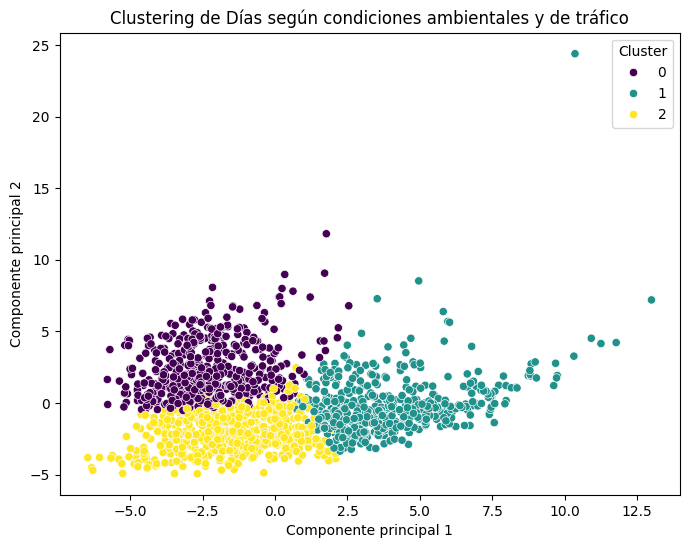

In [ ]:
# Entrenar modelo K-Means con número óptimo de clusters, que en este caso es 3
kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar resultados al dataframe
df['Cluster'] = clusters

# Visualizar clusters en el espacio reducido por PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Clustering de Días según condiciones ambientales y de tráfico')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.show()

**Visualizar variables por cluster**

Usa gráficos para interpretar visualmente los clusters:

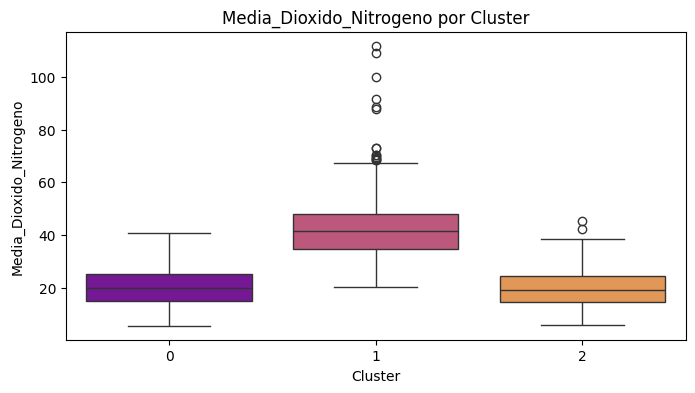

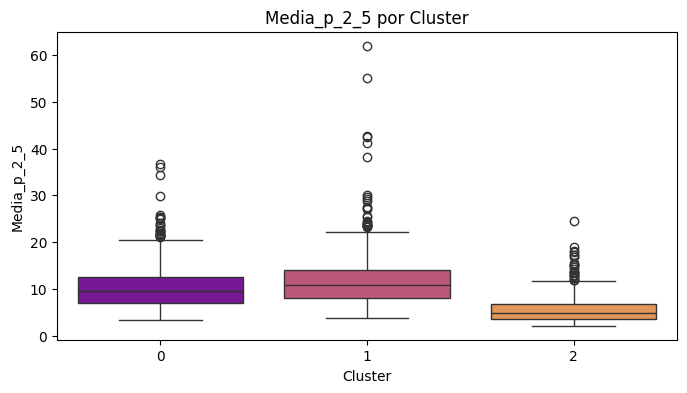

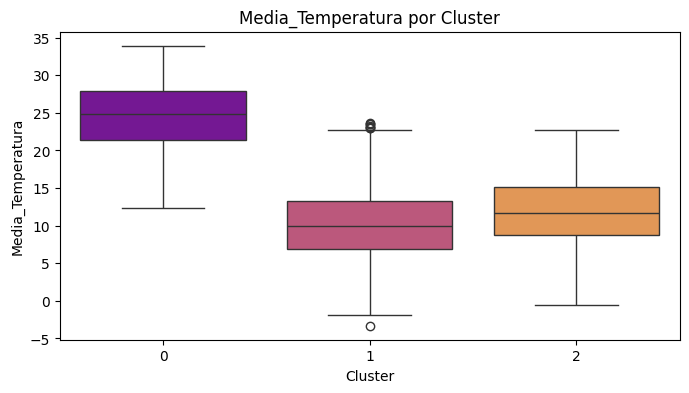

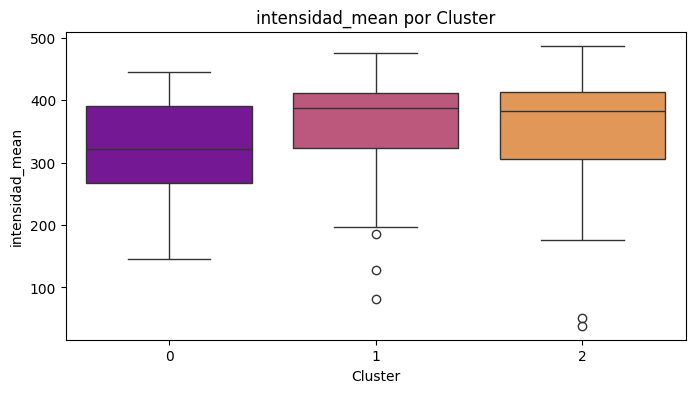

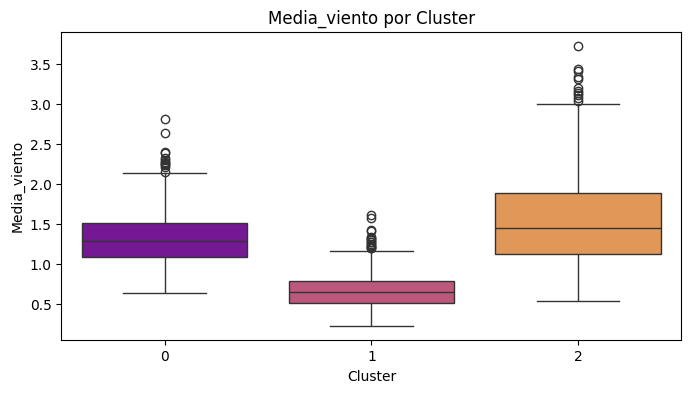

In [ ]:
# Boxplots por cluster
variables_de_interes = ['Media_Dioxido_Nitrogeno', 'Media_p_2_5', 'Media_Temperatura', 'intensidad_mean', 'Media_viento']

for var in variables_de_interes:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster', y=var, data=df, palette='plasma')
    plt.title(f'{var} por Cluster')
    plt.show()


**Resumen interpretativo de los gráficos**

**1. Media_Temperatura por Cluster**

Cluster 0 (🔵):
Temperaturas más bajas (mediana ≈10.9°C), con poca dispersión. Coincide con días fríos y estables que favorecen el estancamiento de contaminantes.

Outliers: Pocos, sugiere estabilidad térmica.

Cluster 1 (🟡):
Temperaturas ligeramente superiores al Cluster 0 (≈11.8°C), pero aún bajas. La mayor dispersión en el gráfico podría indicar variabilidad en días fríos con episodios de viento.

Cluster 2 (🟢):
Mediana significativamente más alta (≈24.3°C), confirmando días cálidos. La amplitud del rango intercuartil refleja fluctuaciones térmicas típicas de días soleados con alta radiación.

Relación con calidad del aire: El frío en Cluster 0 y el calor en Cluster 2 son críticos para explicar los patrones de contaminación (NO₂ alto en frío, ozono alto en calor).

**2. Media_Dioxido_Nitrogeno (NO₂) por Cluster**

Cluster 0 (🔵):
Concentraciones más altas de NO₂, con mediana elevada y dispersión limitada. Refleja emisiones intensas de tráfico y falta de ventilación.

Outliers: Algunos valores extremos podrían asociarse a picos horarios de tráfico.

Cluster 1 (🟡):
Niveles más bajos que Cluster 0, a pesar de tráfico alto. El viento (mayor que en Cluster 0) explica esta reducción.

Cluster 2 (🟢):
Valores intermedios-bajos. La menor actividad de tráfico y la formación de ozono (que compite químicamente con el NO₂) justifican este comportamiento.

Contraste clave: Cluster 0 vs. Cluster 1 demuestran cómo el viento mitiga el impacto del tráfico en la calidad del aire.

**3. intensidad_mean (Tráfico) por Cluster**

Cluster 0 (🔵):
Intensidad máxima más alta (≈19,500), con poca variabilidad. Corrobora días con alta congestión, típicos de condiciones urbanas estables.

Cluster 1 (🟡):
Intensidad similar a Cluster 0, pero con mayor dispersión. Sugiere fluctuaciones en el tráfico, posiblemente ligadas a eventos meteorológicos (ej. lluvia) que reducen su impacto.

Cluster 2 (🟢):
Valores más bajos y menor dispersión. Coincide con días de menor actividad urbana, posiblemente por condiciones cálidas que desincentivan desplazamientos.

Paradoja: Aunque Clusters 0 y 1 tienen tráfico alto, la calidad del aire difiere radicalmente por el viento y la humedad.

**4. Media_viento por Cluster**

Cluster 0 (🔵):
Velocidades mínimas (mediana baja), confirmando mala dispersión. Esto explica la acumulación de NO₂ y partículas.

Cluster 1 (🟡):
Viento más fuerte que en Cluster 0, con cierta variabilidad. Este flujo atmosférico "limpia" el aire a pesar del tráfico.

Cluster 2 (🟢):
Viento moderado, pero suficiente para dispersar partículas primarias (NO₂, PMs). No evita la formación de ozono, que depende más de la radiación solar.

Factor crítico: El viento en Cluster 1 actúa como "sistema de ventilación natural", mientras que su ausencia en Cluster 0 agrava la polución.

**Analizar las características de cada cluster**

Agrupamos el dataset por el cluster asignado y calculamos estadísticas para entender qué distingue a cada uno:

In [ ]:
# Estadísticas por cluster
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary.transpose())  # para ver variables por cluster


Cluster,0,1,2
Media_Dioxido_Nitrogeno,20.353581,42.697462,19.774101
Min_Dioxido_Nitrogeno,9.140927,19.323045,8.110092
Max_Dioxido_Nitrogeno,34.565637,59.812757,32.009174
Media_Humedad_Relativa,37.250902,66.074513,66.712059
Min_Humedad_Relativa,21.569498,52.502058,53.033028
Max_Humedad_Relativa,47.071429,78.150206,74.519266
Media_Dioxido_Azufre,16.634201,30.339910,13.995856
Min_Dioxido_Azufre,7.220077,13.600823,5.598165
Max_Dioxido_Azufre,28.231660,42.613169,23.095413
Media_ozono,75.163523,28.506399,55.591637


In [ ]:


# Estadísticas por cluster
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)

# Save cluster_summary to a CSV file
cluster_summary.transpose().to_csv('cluster_summary.csv')


### **🚩 Resumen interpretativo de los Clusters (0, 1, 2)**

| Cluster | Características principales               | Calidad del aire  | Condiciones ambientales                          | Riesgo ambiental |
| ------- | ----------------------------------------- | ----------------- | ------------------------------------------------ | ---------------- |
| **0**   | Contaminación **alta**, frío, poco viento | **Mala**          | Frío, húmedo, estancado, tráfico alto            | **Alto**         |
| **1**   | Aire **limpio**, frío y húmedo            | **Buena**         | Temperaturas bajas, ozono medio, viento moderado | **Bajo-medio**   |
| **2**   | Ozono **alto**, cálido y seco             | **Regular-buena** | Días cálidos, baja humedad, tráfico bajo         | **Medio**        |


***Interpretación grupo por grupo:***



**🔵 Cluster 0**

— Contaminación más alta

NO₂, SO₂, PM2.5 y PM10: los más elevados.

Ozono: el más bajo.

Temperatura: la más baja (≈ 10.9 °C).

Humedad: alta (≈ 66%).

Presión barométrica: la más alta.

Viento: el más bajo → mala dispersión de contaminantes.

Tráfico: más intenso (intensidad_max ≈ 19,500).

AQI personalizado: 82.15, el más alto → peor calidad del aire.

Eventos especiales: ligeramente más frecuentes.

🧩 Interpretación: Este cluster representa episodios de alta contaminación urbana, asociados a condiciones frías, húmedas y estables, con escasa ventilación. El aire tiende a estancarse, aumentando concentraciones de NO₂ y partículas.

**🟡 Cluster 1**

— Buena calidad del aire, condiciones frías

NO₂, SO₂, PM2.5, PM10: bajos.

Ozono: intermedio (≈ 55.3).

Temperatura: baja (≈ 11.8 °C).

Humedad: la más alta.

Viento: más fuerte que Cluster 0.

Tráfico: también alto, pero no impacta tanto.

AQI personalizado: 81.9 → buena calidad del aire.

🧩 Interpretación: Corresponde a días fríos y húmedos, pero con mejores condiciones de ventilación que evitan la acumulación de contaminantes. A pesar del tráfico, la calidad del aire se mantiene aceptable. Puede deberse a circulación atmosférica favorable o lluvia reciente.

**🟢 Cluster 2**

— Días cálidos y secos con alto ozono

Ozono: muy alto (≈ 75.2).

NO₂, SO₂, PMs: valores moderados o bajos.

Temperatura: la más alta (≈ 24.3 °C).

Humedad: la más baja (≈ 37.3%).

Viento: moderado.

Tráfico: más bajo.

AQI personalizado: 79.8 → calidad regular-buena.

🧩 Interpretación: Este grupo representa días calurosos con fuerte radiación solar, lo cual fomenta la formación de ozono troposférico. Aunque las partículas y gases primarios están bajos, el ozono puede afectar la salud, especialmente a grupos sensibles.

**✅ Conclusión**

Cluster 0 es el más preocupante por su combinación de alta concentración de contaminantes y condiciones meteorológicas desfavorables.

Cluster 1 muestra que incluso con tráfico intenso, es posible mantener buena calidad del aire con ayuda del clima.

Cluster 2 alerta sobre el ozono como contaminante secundario predominante en días soleados.


### **🏹 Cruzar con nuestro AQI personalizado**

Aunque no usaste el AQI personalizado para crear los clusters, puedes ahora evaluar cómo se distribuye en cada grupo:

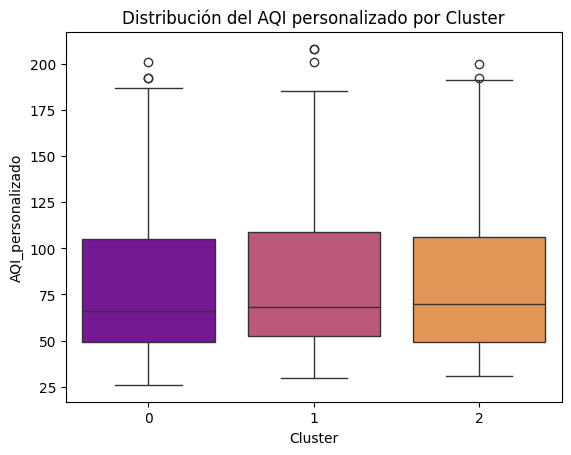

In [ ]:
sns.boxplot(x='Cluster', y='AQI_personalizado', data=df, palette='plasma')
plt.title('Distribución del AQI personalizado por Cluster')
plt.show()


**Interpretación:**




**Grupo 0 (Morado):** Presenta la mediana más alta del ICA, lo que indica una calidad del aire consistentemente deficiente. El amplio ICA sugiere una variabilidad considerable en el ICA diario dentro de este grupo, a pesar de la mala calidad del aire en general. El alto valor máximo del ICA (valor atípico) indica episodios de aire gravemente contaminado. Esto concuerda con las características descritas previamente de este grupo, a saber, los altos niveles de contaminantes (NO₂, SO₂, PM₂, PM₁₂) debido a la baja velocidad del viento y la inversión térmica.




**Grupo 1 (Rosa):** Presenta una mediana del ICA significativamente menor que la del Grupo 0, lo que sugiere una mejor calidad del aire en general. El RIQ es menor, lo que indica una menor variabilidad diaria. Esto concuerda con la descripción de este grupo, donde una mejor ventilación, a pesar del alto tráfico, resultó en una calidad del aire aceptable en días que aún eran fríos y húmedos.




**Grupo 2 (Naranja):** Presenta un ICA medio similar al del Grupo 1, pero con un valor máximo del ICA más alto (valor atípico), lo que indica algunos días con peor calidad del aire dentro de este grupo. El ICA es relativamente moderado. Este grupo refleja días con altos niveles de ozono debido a las altas temperaturas y la insolación, pero con niveles más bajos de otros contaminantes, lo que resulta en un perfil del ICA menos consistente en comparación con el Grupo 1.




**En general:** El diagrama de caja muestra eficazmente los distintos perfiles del ICA asociados a cada clúster. Confirma visualmente los hallazgos del modelo de aprendizaje no supervisado, mostrando cómo las diferentes condiciones meteorológicas y patrones de tráfico impactan significativamente la calidad del aire en Madrid. Los valores atípicos en cada clúster resaltan la existencia de eventos extremos dentro de cada régimen de calidad del aire.

### **📍 Asociar a condiciones externas**

Si tienes datos como evento_especial, puedes evaluar si ciertos clusters tienen más eventos especiales, restricciones de tráfico, etc.


In [ ]:
df.groupby('Cluster')['evento_especial'].mean()


,evento_especial
Cluster,
0,0.015444
1,0.022634
2,0.020183


**📌 Resumen de evento_especial por cluster**

La variable evento_especial representa la proporción de registros en cada cluster que corresponden a días con eventos especiales (festividades, manifestaciones, eventos deportivos, etc.). Sus valores están expresados como promedios entre 0 y 1.

| Cluster | Valor medio `evento_especial` | Interpretación                                                                                                                                                                                                                |
| ------- | ----------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 0.0154 (1.54%)                | Este cluster presenta la **menor proporción de días con eventos especiales**. Es decir, la mayoría de los datos en este grupo corresponden a días normales sin alteraciones inusuales.                                        |
| **1**   | 0.0226 (2.26%)                | Es el cluster con la **mayor proporción** de días con eventos especiales. Aunque la diferencia es pequeña, sugiere que las condiciones atmosféricas y de tráfico aquí podrían estar algo más influenciadas por estos eventos. |
| **2**   | 0.0201 (2.01%)                | También presenta una **ligera incidencia de eventos especiales**, por encima del cluster 0, pero por debajo del cluster 1.                                                                                                    |


**🧠 Conclusión interpretativa**

En general, los valores de evento_especial son bajos en todos los clusters, lo que indica que los eventos especiales no dominan el comportamiento de los datos.

Cluster 1 podría estar ligeramente más asociado a alteraciones propias de días con eventos especiales, lo que tal vez contribuya a algunas de sus características como menor temperatura y mayor presión.

Cluster 0, al tener la menor incidencia de eventos, refleja condiciones más representativas de la normalidad diaria.

## **🌈 Etiquetas sugeridas para los clusters**

**🌫️ Cluster 0 → "Alta Contaminación Urbana"**

Contaminantes muy altos (NO₂, SO₂, PMs).

Poco viento, frío y húmedo.

Alta presión → aire estancado.

Tráfico muy intenso.

👉 Etiqueta alternativa: “Episodios de Inversión Térmica” o “Contaminación Estancada”.

**🌥️ Cluster 1 → "Aire Limpio y Frío"**

Baja contaminación.

Alta humedad y viento moderado.

Buena dispersión atmosférica.

Temperatura baja.

👉 Etiqueta alternativa: “Ventilación Atmosférica Favorable”.

**☀️ Cluster 2  → "Ozono Fotoquímico Estival"**

Alto ozono, baja humedad.

Temperaturas altas y tráfico bajo.

Contaminantes primarios bajos.

👉 Etiqueta alternativa: “Día Soleado con Ozono” o “Contaminación Secundaria”.



## **✅ Conclusiones Generales**
Clima y ventilación son factores clave que explican los niveles de contaminación más allá del tráfico.

Cluster 0 representa el mayor riesgo ambiental por estancamiento atmosférico y acumulación de contaminantes.

Cluster 1 evidencia que condiciones meteorológicas favorables pueden mitigar el impacto del tráfico en la calidad del aire.

Cluster 2 alerta sobre la importancia del ozono en días soleados, aunque los niveles de tráfico y partículas sean bajos.

Eventos especiales tienen poca incidencia global, pero una leve concentración en Clusters 1 y 2 sugiere alguna relación con variabilidad ambiental.

## **🔍 Conclusión Final**

El análisis realizado demuestra cómo las técnicas de aprendizaje no supervisado, como el clustering, pueden ser herramientas poderosas para identificar patrones ocultos en datos complejos relacionados con la calidad del aire. A través de la segmentación en tres clusters bien diferenciados, se logró caracterizar las condiciones ambientales y de tráfico que influyen en los niveles de contaminación en Madrid.

Los resultados destacan la importancia de factores meteorológicos, como la temperatura, la humedad y el viento, en la dispersión o acumulación de contaminantes. Además, se evidenció que, aunque el tráfico es un factor clave, su impacto puede ser mitigado por condiciones atmosféricas favorables. Por otro lado, el ozono troposférico emergió como un contaminante secundario relevante en días cálidos y soleados, subrayando la necesidad de estrategias específicas para su control.

Este enfoque no solo permite una mejor comprensión de los patrones de contaminación, sino que también ofrece una base sólida para el diseño de políticas públicas más efectivas. Por ejemplo, las medidas de restricción de tráfico podrían ser más eficaces si se implementan en días con condiciones meteorológicas desfavorables, como los representados por el Cluster 0.

En resumen, este trabajo proporciona una visión integral de los factores que afectan la calidad del aire en entornos urbanos y refuerza la utilidad del análisis de datos para informar decisiones orientadas a mejorar la salud pública y la sostenibilidad ambiental.